# Analysing polarised neutron reflectometry data (mark2)
`refnx` recently added the ability to perform polarised neutron reflectometry analysis in v0.1.51, both non-spin flip and spin flip. Here we analyse datasets that uses magnetic films and PNR as an extra contrast. The datasets of interest have the structure:

`Si | SiO2 | Permalloy | Au | 2-mercaptoethanol | D2O`

In [1]:
# some necessary imports
from importlib import resources

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import refnx
from refnx.analysis import Parameter, Objective, CurveFitter, GlobalObjective
from refnx.reflect import (
    SLD,
    Slab,
    Structure,
    MagneticSlab,
    PolarisedReflectModel,
    SpinChannel,
    pnr_data_and_generative,
)
from refnx.dataset import Data1D, PolarisedReflectDatasets

In [2]:
# create datasets from the NSF PNR data
pth = resources.files(refnx.reflect)
dd = "c_PLP0007882.dat"
uu = "c_PLP0007885.dat"

file_path_uu = pth / f"tests/{uu}"
file_path_dd = pth / f"tests/{dd}"

data_uu = Data1D(file_path_uu)
data_dd = Data1D(file_path_dd)

combined = PolarisedReflectDatasets(up_up=data_uu, down_down=data_dd)

In [3]:
# create SLD (Scattering Length Density) objects for each of the materials
si = SLD(2.07, name="Si")
sio2 = SLD(3.47, name="SiO2")
au = SLD(4.66, name="Au")
mercapto = SLD(3.49, name="2-mercaptoethanol")
d2o = SLD(6.35, name="d2o")

py = SLD(9.0, name="permalloy")

In [4]:
# Now make Slabs that describe each layer. These can either be made from SLD objects,
# or by using the `Slab` constructor directly.

# sio2 slab has a thickness of 20 and roughness of 4 with the Si fronting medium
sio2_l = sio2(20, 4)

au_l = au(215, 4)
mercapto_l = mercapto(8, 4)
d2o_l = d2o(0, 4)

Now let's make the Permalloy layer. To do this we need to utilise a `MagneticSlab` Component. The value of 1.75 represents a magnetic SLD correction of $1.75\times 10^{-6}\\A^{-2}$. The value of `thetaM=90` (degrees) represents the angle of the magnetic moment in the plane of the sample. For the applied magnetic field to be the plane of the sample `Aguide=270` or `90`. For the magnetic moment to be parallel or antiparallel to the applied field `thetaM=90` or `270` degrees respectively.

In [5]:
# now make the Py layer
py_thickness = Parameter(50, name="Py thickness")
py_roughness = Parameter(5, name="Py roughness")

py_l = MagneticSlab(py_thickness, py, py_roughness, 1.75, 90.0, name="Py slab")

In [6]:
s = si | sio2_l | py_l | au_l | mercapto_l | d2o_l

In [7]:
# Note that we're using the same structure to describe both spin channels.
# If you want to specify a different scale factor and bkg for each SpinChannel
# you must provide 4 numbers during the construction of PolarisedReflectModel
# (even if you don't have all four spin channels).
# Otherwise the same scale factor/bkg will be used for all.
scale = [1.0] * 4
bkg = [1e-7] * 4
model = PolarisedReflectModel(
    s,
    scales=scale,
    bkgs=bkg,
    dq_type="pointwise",
)

In [8]:
objective = Objective(model, combined)

In [9]:
# select the parameters to be fitted and their bounds
model.scale[0].setp(vary=True, bounds=(0.9, 1.1))  # UU
model.scale[-1].setp(vary=True, bounds=(0.9, 1.1))  # DD

model.bkg[0].setp(vary=True, bounds=(1e-7, 5e-6))
model.bkg[-1].setp(vary=True, bounds=(1e-7, 5e-6))

sio2_l.thick.setp(vary=True, bounds=(10, 25))
sio2_l.rough.setp(vary=True, bounds=(1, 8))

py_thickness.setp(vary=True, bounds=(38, 55))
py_roughness.setp(vary=True, bounds=(1, 8))
py.real.setp(vary=True, bounds=(9, 9.5))
py_l.rhoM.setp(vary=True, bounds=(1.5, 3.0))

au_l.thick.setp(vary=True, bounds=(200, 240))
au_l.rough.setp(vary=True, bounds=(1, 8))
au.real.setp(vary=True, bounds=(4.5, 4.66))

mercapto_l.thick.setp(vary=True, bounds=(5, 15))
mercapto_l.rough.setp(vary=True, bounds=(1, 8))
mercapto.real.setp(vary=True, bounds=(3, 4))

d2o_l.rough.setp(vary=True, bounds=(1, 8))
d2o.real.setp(vary=True, bounds=(6.2, 6.36))

In [10]:
fitter = CurveFitter(objective)
fitter.fit("differential_evolution", seed=1, polish=False);

-1265.3234388262526: : 84it [00:11,  7.26it/s]


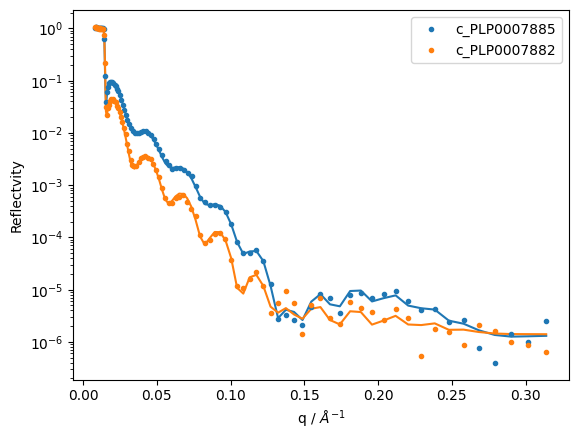

In [11]:
pdg = pnr_data_and_generative(objective)

fig = plt.figure()
ax = fig.add_subplot(111)

for dg in pdg:
    dta, generative = dg
    p = ax.plot(dta.x, generative)
    color = p[0].get_color()
    ax.errorbar(
        dta.x,
        dta.y,
        dta.y_err,
        ms=3,
        marker="o",
        lw=0,
        label=dta.name,
        color=color,
    )

plt.yscale("log")
plt.xlabel("q / $\\AA^{-1}$")
plt.ylabel("Reflectvity")
plt.legend();

In [12]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
